<a href="https://colab.research.google.com/github/shirsneh/RAG_projects/blob/main/Enhance_LLMs_using_RAG_and_Hugging_Face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enhance LLMs using RAG and Hugging Face

In [2]:
!pip install --user transformers datasets torch faiss-cpu wget

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 23.6 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=79639a6d38c77e7b6e552ec9a6a0787686513a2d8a6621f643d3872320da4fbf
  Stored in directory: /root/.cache/pip/wheels/01/46/3b/e29ffbe4ebe614ff224bad40fc6a5773a67a163251585a13a9
Successfully built wget


In [3]:
!pip install --user matplotlib scikit-learn

In [1]:
import wget
import torch
import numpy as np
import random
from transformers import DPRContextEncoder, DPRContextEncoderTokenizer
from transformers import DPRQuestionEncoder, DPRQuestionEncoderTokenizer
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
import numpy as np

In [2]:
def tsne_plot(data):
    # Apply t-SNE to reduce to 3D
    tsne = TSNE(n_components=3, random_state=42,perplexity=data.shape[0]-1)
    data_3d = tsne.fit_transform(data)

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    num_points = len(data_3d)
    colors = plt.cm.tab20(np.linspace(0, 1, num_points))
    for idx, point in enumerate(data_3d):
        ax.scatter(point[0], point[1], point[2], label=str(idx), color=colors[idx])
    ax.set_xlabel('TSNE Component 1')
    ax.set_ylabel('TSNE Component 2')
    ax.set_zlabel('TSNE Component 3')
    plt.title('3D t-SNE Visualization')
    plt.legend(title='Input Order')
    plt.show()

## Downloading the text file

In [3]:
filename = 'companyPolicies.txt'
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/6JDbUb_L3egv_eOkouY71A.txt'

# Use wget to download the file
wget.download(url, out=filename)
print('file downloaded')

file downloaded


## Reading and preprocessing the data

In [4]:
def read_and_split_text(filename):
    with open(filename, 'r', encoding='utf-8') as file:
        text = file.read()
    paragraphs = text.split('\n')
    paragraphs = [para.strip() for para in paragraphs if len(para.strip()) > 0]
    return paragraphs
paragraphs = read_and_split_text('companyPolicies.txt')
paragraphs[0:10]

#for checking
for i in range(4):
    print(f"sample: {i} paragraph: {paragraphs[i]} \n" )

sample: 0 paragraph: 1.	Code of Conduct 

sample: 1 paragraph: Our Code of Conduct outlines the fundamental principles and ethical standards that guide every member of our organization. We are committed to maintaining a workplace that is built on integrity, respect, and accountability. 

sample: 2 paragraph: Integrity: We hold ourselves to the highest ethical standards. This means acting honestly and transparently in all our interactions, whether with colleagues, clients, or the broader community. We respect and protect sensitive information, and we avoid conflicts of interest. 

sample: 3 paragraph: Respect: We embrace diversity and value each individual's contributions. Discrimination, harassment, or any form of disrespectful behavior is unacceptable. We create an inclusive environment where differences are celebrated and everyone is treated with dignity and courtesy. 



## Building the retriever: Encoding and indexing

### Tokenization

In [5]:
%%capture
context_tokenizer = DPRContextEncoderTokenizer.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')
context_tokenizer

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizer'.


In [6]:
text = [("How are you?", "I am fine."), ("What's up?", "Not much.")]
print(text)

[('How are you?', 'I am fine.'), ("What's up?", 'Not much.')]


In [7]:
tokens_info=context_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=256)
tokens_info

{'input_ids': tensor([[ 101, 2129, 2024, 2017, 1029,  102, 1045, 2572, 2986, 1012,  102],
        [ 101, 2054, 1005, 1055, 2039, 1029,  102, 2025, 2172, 1012,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

**token_type_ids:** These are segment embeddings used to distinguish different sentences or segments within the input. This is particularly useful in tasks that involve multiple types of input, such as question answering, where questions and context may need to be differentiated.

**attention_mask:** The attention mask indicates which tokens should be attended to by the model. It has a value of 1 for actual tokens in the input sentences and 0 for padding tokens, ensuring that the model focuses only on meaningful data.

**input_ids:** These represent the indices of tokens in the tokenizer's vocabulary. To translate these indices back into readable tokens, you can use the method convert_ids_to_tokens provided by the tokenizer.

In [8]:
for s in tokens_info['input_ids']:
   print(context_tokenizer.convert_ids_to_tokens(s))

['[CLS]', 'how', 'are', 'you', '?', '[SEP]', 'i', 'am', 'fine', '.', '[SEP]']
['[CLS]', 'what', "'", 's', 'up', '?', '[SEP]', 'not', 'much', '.', '[SEP]']


### Encoding

In [9]:
context_encoder = DPRContextEncoder.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/dpr-ctx_encoder-single-nq-base were not used when initializing DPRContextEncoder: ['ctx_encoder.bert_model.pooler.dense.bias', 'ctx_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRContextEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRContextEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The context_tokenizer and context_encoder work together to process text data, transforming paragraphs into contextual embeddings suitable for further NLP tasks. Here's how these components are applied to the first 20 paragraphs from a list:

The context_tokenizer takes the first 20 paragraphs and converts each into a sequence of token IDs, formatted specifically as input to a PyTorch model. This process includes:

**Padding:** To ensure uniformity, shorter text sequences are padded with zeros to reach the specified maximum length of 256 tokens.

**Truncation:** Longer texts are cut off at 256 tokens to maintain consistency across all inputs.

The tokenized data is then passed to the context_encoder, which processes these token sequences to produce contextual embeddings. Each output embedding vector from the encoder represents the semantic content of its corresponding paragraph, encapsulating key informational and contextual nuances.
The encoder outputs a PyTorch tensor where each row corresponds to a different paragraph's embedding. The shape of this tensor, determined by the number of paragraphs processed and the embedding dimensions, reflects the detailed, contextualized representation of each paragraph's content.

In [10]:
random.seed(42)
random.shuffle(paragraphs)

In [11]:
tokens=context_tokenizer( paragraphs[:20], return_tensors='pt', padding=True, truncation=True, max_length=256)
tokens
outputs=context_encoder(**tokens)
outputs.pooler_output

tensor([[ 0.1740,  0.3478,  0.1819,  ..., -0.4684, -0.5166,  0.0325],
        [ 0.7075,  0.6072,  0.0172,  ..., -0.1247,  0.4195, -0.4397],
        [ 0.5345, -0.3251, -0.0033,  ..., -0.1102,  0.0141,  0.1342],
        ...,
        [ 0.5488,  0.3156,  0.5122,  ..., -0.3317, -0.5188, -0.0304],
        [ 0.6059,  0.2979, -0.1750,  ..., -0.2875, -0.0238, -0.3538],
        [ 0.1947, -0.1456,  0.1621,  ...,  0.0998,  0.1219,  0.4370]],
       grad_fn=<SliceBackward0>)

**t-SNE (t-Distributed Stochastic Neighbor Embedding)** is an effective method for visualizing high-dimensional data, making it particularly useful for analyzing outputs from DPRContextEncoder models. The DPRContextEncoder encodes passages into dense vectors that capture their semantic meanings within a high-dimensional space. Applying t-SNE to these dense vectors allows you to reduce their dimensionality to two or three dimensions. This reduction creates a visual representation that preserves the relationships between passages, enabling you to explore clusters of similar passages and discern patterns that might otherwise remain hidden in the high-dimensional space. The resulting plots provide insights into how the model differentiates between different types of passages and reveal the inherent structure within the encoded data.

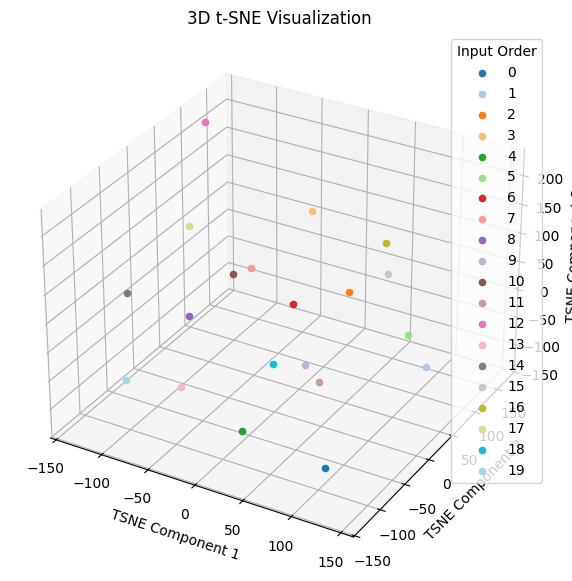

In [12]:
tsne_plot(outputs.pooler_output.detach().numpy())

Samples 9,11 and 18 are closer to each other on the graph shown above. Let's view the corresponding paragraphs:

In [22]:
print("sample 9:", paragraphs[9])
print("sample 11:", paragraphs[11])
print("sample 18:", paragraphs[18])

sample 9: Policy Purpose: The Smoking Policy has been established to provide clear guidance and expectations concerning smoking on company premises. This policy is in place to ensure a safe and healthy environment for all employees, visitors, and the general public.
sample 11: Consequences: Violation of this policy may result in disciplinary actions, up to and including termination of employment. Legal action may also be pursued when necessary.
sample 18: Your adherence to this policy is appreciated as it helps to maintain a safe and drug-free workplace for all.


Both samples discuss diversity. Rather than relying solely on visual inspection, distances between embeddings are employed to determine the relevance of retrieved documents or passages. This involves comparing the query’s embedding with the embeddings of candidate documents, enabling a precise and objective measure of relevance.

### Aggregation

In [23]:
def encode_contexts(text_list):
    # Encode a list of texts into embeddings
    embeddings = []
    for text in text_list:
        inputs = context_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=256)
        outputs = context_encoder(**inputs)
        embeddings.append(outputs.pooler_output)
    return torch.cat(embeddings).detach().numpy()
context_embeddings = encode_contexts(paragraphs)

## Creating and populating the FAISS index

In [24]:
import faiss

embedding_dim = 768
context_embeddings_np = np.array(context_embeddings).astype('float32')
index = faiss.IndexFlatL2(embedding_dim)
index.add(context_embeddings_np)

### DPR question encoder and tokenizer

**The Dense Passage Retriever (DPR)** is instrumental in effectively retrieving relevant documents or passages for a given question. Let's load the DPRQuestionEncoder and DPRQuestionEncoderTokenizer for encoding questions:

**Question encoder:** The DPR question encoder is designed to convert questions into dense vector embeddings. This process enhances the system's ability to efficiently match and retrieve relevant content from a vast corpus, which is vital for answering queries accurately.

**Tokenizer:** The tokenizer for the DPR question encoder plays a crucial role in preparing input questions by:

**Standardizing text:** It converts raw text into a standardized sequence of token IDs.

**Processing inputs:** These token IDs are then processed by the question encoder to produce embeddings that effectively represent the semantic intent of the questions.

In [25]:
# Load DPR question encoder and tokenizer
question_encoder = DPRQuestionEncoder.from_pretrained('facebook/dpr-question_encoder-single-nq-base')
question_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained('facebook/dpr-question_encoder-single-nq-base')

config.json:   0%|          | 0.00/493 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/dpr-question_encoder-single-nq-base were not used when initializing DPRQuestionEncoder: ['question_encoder.bert_model.pooler.dense.bias', 'question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRQuestionEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRQuestionEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

## Example query and context retrieval

This example will help illustrate how the different components of the system interact to perform a complete retrieval task.

In [26]:
def search_relevant_contexts(question, question_tokenizer, question_encoder, index, k=5):
    """
    Searches for the most relevant contexts to a given question.

    Returns:
    tuple: Distances and indices of the top k relevant contexts.
    """
    question_inputs = question_tokenizer(question, return_tensors='pt')
    question_embedding = question_encoder(**question_inputs).pooler_output.detach().numpy()

    # Search the index to retrieve top k relevant contexts
    D, I = index.search(question_embedding, k)

    return D, I

**D (Distances):** This array contains the distances between the query embedding and the retrieved document embeddings. The distances measure the similarity between the query and each document, where lower distances indicate higher relevance. These values help determine how closely each retrieved context matches the query.

**I (Indices):** This array holds the indices of the paragraphs within the paragraphs array that have been identified as the most relevant to the query. These indices correspond to the positions of the paragraphs in the original data array, allowing for easy retrieval of the actual text content.

## **Enhancing response generation with LLMs**

### GPT2 model and tokenizer

In [27]:
tokenizer = AutoTokenizer.from_pretrained("openai-community/gpt2")
model = AutoModelForCausalLM.from_pretrained("openai-community/gpt2")
model.generation_config.pad_token_id = tokenizer.pad_token_id

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [28]:
contexts= "What is a large language model?"
inputs = tokenizer(contexts, return_tensors='pt', max_length=1024, truncation=True)
print(inputs)

{'input_ids': tensor([[2061,  318,  257, 1588, 3303, 2746,   30]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}


In [29]:
summary_ids = model.generate(inputs['input_ids'], max_length=50, num_beams=4, early_stopping=True,
                             pad_token_id=tokenizer.eos_token_id)
summary_ids

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


tensor([[ 2061,   318,   257,  1588,  3303,  2746,    30,   198,   198,    32,
          1588,  3303,  2746,   318,   257,   900,   286,  3173,   326,  6901,
           703,   257,  3303,   815, 17438,   287,   257,  1813,  4732,    13,
           198,   198,    32,  1588,  3303,  2746,   318,   257,   900,   286,
          3173,   326,  6901,   703,   257,  3303,   815, 17438,   287,   257]])

In [33]:
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
print(summary)

What is a large language model?

A large language model is a set of rules that describe how a language should behave in a given context.

A large language model is a set of rules that describe how a language should behave in a


### Comparing answer generation: With and without DPR contexts

Generating answers directly from questions

In [34]:
def generate_answer_without_context(question):
    inputs = tokenizer(question, return_tensors='pt', max_length=1024, truncation=True)
    summary_ids = model.generate(inputs['input_ids'], max_length=150, min_length=40, length_penalty=2.0,
                                 num_beams=4, early_stopping=True,pad_token_id=tokenizer.eos_token_id)
    answer = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return answer

question = "what is mobile policy?"
answer = generate_answer_without_context(question)

print("Answer:", answer)

Answer: what is mobile policy?

Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other electronic devices in the United States. Mobile policy is a set of rules and regulations that govern the use of mobile phones and other


Generating answers with DPR contexts

In [35]:
def generate_answer(question, contexts):
    input_text = question + ' ' + ' '.join(contexts)
    inputs = tokenizer(input_text, return_tensors='pt', max_length=1024, truncation=True)

    # Generate output using GPT2
    summary_ids = model.generate(inputs['input_ids'], max_new_tokens=50, min_length=40, length_penalty=2.0,
                                 num_beams=4, early_stopping=True,pad_token_id=tokenizer.eos_token_id)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

question = "what is mobile policy?"

_,I =search_relevant_contexts(question, question_tokenizer, question_encoder, index, k=5)
top_contexts = [paragraphs[idx] for idx in I[0]]
answer = generate_answer(question, top_contexts)
print("Generated Answer:", answer)

Generated Answer: what is mobile policy? 4.	Mobile Phone Policy The Mobile Phone Policy sets forth the standards and expectations governing the appropriate and responsible usage of mobile devices in the organization. The purpose of this policy is to ensure that employees utilize mobile phones in a manner consistent with company values and legal compliance. Monitoring: The company retains the right to monitor internet and email usage for security and compliance purposes. Acceptable Use: Mobile devices are primarily intended for work-related tasks. Limited personal usage is allowed, provided it does not disrupt work obligations. The Mobile Phone Policy is aimed at promoting the responsible and secure use of mobile devices in line with legal and ethical standards. Every employee is expected to comprehend and abide by these guidelines. Regular reviews of the policy ensure its ongoing alignment with evolving technology and security best practices.

The Mobile Phone Policy sets forth the sta

### Analysis

In [37]:
def generate_answer(contexts, max_len=50, min_len=40, length_penalty=2.0, num_beams=4):
    # Concatenate the retrieved contexts to form the input to BAR
    input_text = ' '.join(contexts)
    inputs = tokenizer(input_text, return_tensors='pt', max_length=1024, truncation=True)

    # Generate output using GPT2
    summary_ids = model.generate(
        inputs['input_ids'],
        max_new_tokens=max_len,
        min_length=min_len,
        length_penalty=length_penalty,
        num_beams=num_beams,
        early_stopping=True
    )
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

question = "what is mobile policy?"

# Retrieve relevant contexts
_, I = search_relevant_contexts(question, question_tokenizer, question_encoder, index, k=5)
top_contexts = [paragraphs[idx] for idx in I[0]]

# Test different generation settings
settings = [
    (50, 50, 1.0, 2),
    (120, 30, 2.0, 4),
    (100, 20, 2.5, 6)
]
for setting in settings:
    answer = generate_answer(top_contexts, *setting)
    print(f"Settings: max_new_tokens={setting[0]}, min_length={setting[1]}, length_penalty={setting[2]}, num_beams={setting[3]}")
    print("Generated Answer:", answer)
    print("\n" + "="*80 + "\n")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Settings: max_new_tokens=50, min_length=50, length_penalty=1.0, num_beams=2
Generated Answer: 4.	Mobile Phone Policy The Mobile Phone Policy sets forth the standards and expectations governing the appropriate and responsible usage of mobile devices in the organization. The purpose of this policy is to ensure that employees utilize mobile phones in a manner consistent with company values and legal compliance. Monitoring: The company retains the right to monitor internet and email usage for security and compliance purposes. Acceptable Use: Mobile devices are primarily intended for work-related tasks. Limited personal usage is allowed, provided it does not disrupt work obligations. The Mobile Phone Policy is aimed at promoting the responsible and secure use of mobile devices in line with legal and ethical standards. Every employee is expected to comprehend and abide by these guidelines. Regular reviews of the policy ensure its ongoing alignment with evolving technology and security best p

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Settings: max_new_tokens=120, min_length=30, length_penalty=2.0, num_beams=4
Generated Answer: 4.	Mobile Phone Policy The Mobile Phone Policy sets forth the standards and expectations governing the appropriate and responsible usage of mobile devices in the organization. The purpose of this policy is to ensure that employees utilize mobile phones in a manner consistent with company values and legal compliance. Monitoring: The company retains the right to monitor internet and email usage for security and compliance purposes. Acceptable Use: Mobile devices are primarily intended for work-related tasks. Limited personal usage is allowed, provided it does not disrupt work obligations. The Mobile Phone Policy is aimed at promoting the responsible and secure use of mobile devices in line with legal and ethical standards. Every employee is expected to comprehend and abide by these guidelines. Regular reviews of the policy ensure its ongoing alignment with evolving technology and security best 